In [1]:
!nvidia-smi
!pip -q install ultralytics==8.* opencv-python tqdm lxml albumentations
from pathlib import Path
import io, zipfile, shutil, random, re, os
from urllib.request import urlopen, Request
from PIL import Image
import xml.etree.ElementTree as ET

Wed Dec  3 23:25:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   35C    P0             53W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
Root_Folder = "/content/"
Project_Path = Path(Root_Folder)
Data_Path = Project_Path / "Data"
GroundTruth_Path  = Project_Path / "GroundTruth"
ZIP_Path = Data_Path / "exdark.zip"
GroundTruth_ZIP = GroundTruth_Path / "ExDark_Groundtruth.zip"
Images_Path = Project_Path / "Data" / "ExDark"
GroundTruthAnnotation_Path = Project_Path / "GroundTruth" / "ExDark_Annno"
Output = Project_Path / "Output"
Output_Masked = Project_Path / "Output_Masked"

Data_Path.mkdir(parents=True, exist_ok=True)
GroundTruth_Path.mkdir(parents=True, exist_ok=True)

print("Project root:", Project_Path)
print("Data dir:", Data_Path)
print("GroundTruth dir:", GroundTruth_Path)

Project root: /content
Data dir: /content/Data
GroundTruth dir: /content/GroundTruth


In [5]:
#Downloading data in colab
if not (Data_Path / "ExDark").exists():
  !pip install -q gdown

  file_id = "1BHmPgu8EsHoFDDkMGLVoXIlCth2dW6Yx"
  gdrive_url = f"https://drive.google.com/uc?id={file_id}"

  print("Downloading ExDARK dataset ...")
  !gdown --fuzzy {gdrive_url} -O {ZIP_Path}

  if not ZIP_Path.exists():
      raise FileNotFoundError(f"Download failed! File not found at {ZIP_Path}")

  print("Extracting files...")
  with zipfile.ZipFile(ZIP_Path, 'r') as zip_ref:
      zip_ref.extractall(Data_Path)

  print("Extraction complete!")

  ZIP_Path.unlink()

  print("Done! ExDARK extracted to:", Data_Path)
else:
  print("ExDARK already present, skipping download.")

Downloading...
From (original): https://drive.google.com/uc?id=1BHmPgu8EsHoFDDkMGLVoXIlCth2dW6Yx
From (redirected): https://drive.google.com/uc?id=1BHmPgu8EsHoFDDkMGLVoXIlCth2dW6Yx&confirm=t&uuid=bffec1d5-d801-48c0-83d5-a8edbee41698
To: /content/Data/exdark.zip
100% 1.49G/1.49G [00:08<00:00, 181MB/s]
Extracting files...
Extraction complete!
Done! ExDARK extracted to: /content/Data


In [6]:
if not (GroundTruth_Path / "ExDark_Annno").exists():
  !pip install -q gdown

  file_id = "1P3iO3UYn7KoBi5jiUkogJq96N6maZS1i"

  print("Downloading ExDARK Groundtruth...")
  !gdown --id {file_id} -O {GroundTruth_ZIP}

  if not GroundTruth_ZIP.exists():
      raise FileNotFoundError(f"Download failed! File not found at {GroundTruth_ZIP}")
  else:
      print("Download complete:", GroundTruth_ZIP)

  print("Extracting files...")
  with zipfile.ZipFile(GroundTruth_ZIP, "r") as zip_ref:
      zip_ref.extractall(GroundTruth_Path)

  print("Extraction complete!")
  print("Groundtruth extracted to:", GroundTruth_Path)

  GroundTruth_ZIP.unlink(missing_ok=True)
else:
  print("ExDARK annotation already present, skipping download.")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1P3iO3UYn7KoBi5jiUkogJq96N6maZS1i
From (redirected): https://drive.google.com/uc?id=1P3iO3UYn7KoBi5jiUkogJq96N6maZS1i&confirm=t&uuid=67488b7e-8ee6-460d-901b-dae75fc329de
To: /content/GroundTruth/ExDark_Groundtruth.zip
100% 5.08M/5.08M [00:00<00:00, 278MB/s]
Download complete: /content/GroundTruth/ExDark_Groundtruth.zip
Extracting files...
Extraction complete!
Groundtruth extracted to: /content/GroundTruth


In [7]:
Images_Format = {".jpg",".jpeg",".png",".bmp"}
Images_Per_Class = {}
Total_Images = 0
Classes = []

for p in sorted(Images_Path.iterdir()):
    if p.is_dir():
        Classes.append(p.name)
        n = len([f for f in p.iterdir() if f.suffix.lower() in Images_Format])
        Images_Per_Class[p.name] = n
        Total_Images += n
Classes_ID = {c:i for i,c in enumerate(Classes)}

print("Classes found under Data/ExDark:", Classes)
print("Total images in Data/ExDark:", Total_Images)
print("Per-class image counts:", Images_Per_Class)

Classes found under Data/ExDark: ['Bicycle', 'Boat', 'Bottle', 'Bus', 'Car', 'Cat', 'Chair', 'Cup', 'Dog', 'Motorbike', 'People', 'Table']
Total images in Data/ExDark: 7363
Per-class image counts: {'Bicycle': 652, 'Boat': 679, 'Bottle': 547, 'Bus': 527, 'Car': 638, 'Cat': 735, 'Chair': 648, 'Cup': 519, 'Dog': 801, 'Motorbike': 503, 'People': 609, 'Table': 505}


In [8]:
Annotations_Per_Class = {}
Total_Annotations = 0

for c in Classes:
    gdir = GroundTruthAnnotation_Path / c
    if gdir.exists():
        n = len([f for f in gdir.iterdir() if f.is_file() and f.suffix==".txt"])
        Annotations_Per_Class[c] = n
        Total_Annotations += n
    else:
        Annotations_Per_Class[c] = 0

print("GroundTruth root:", GroundTruthAnnotation_Path)
print("Total GT .txt files for listed classes:", Total_Annotations)
print("Per-class GT counts (txt files):", Annotations_Per_Class)

GroundTruth root: /content/GroundTruth/ExDark_Annno
Total GT .txt files for listed classes: 7363
Per-class GT counts (txt files): {'Bicycle': 652, 'Boat': 679, 'Bottle': 547, 'Bus': 527, 'Car': 638, 'Cat': 735, 'Chair': 648, 'Cup': 519, 'Dog': 801, 'Motorbike': 503, 'People': 609, 'Table': 505}


In [9]:
def Exdark_Annotation_Line(Line, W, H, Folder_Class):
  Line = Line.strip()
  if not Line or Line.startswith('%'):
    return None

  Parts = re.split(r'[,\s]+', Line)
  if len(Parts) < 5:
    return None

  Class_Name = Parts[0]
  try:
    x, y, w, h = map(float, Parts[1:5])
  except:
    return None

  xmin, ymin = x, y
  xmax, ymax = x + max(0.0, w), y + max(0.0, h)

  xmin = max(0.0, min(float(W), xmin)); ymin = max(0.0, min(float(H), ymin))
  xmax = max(0.0, min(float(W), xmax)); ymax = max(0.0, min(float(H), ymax))
  if xmax <= xmin or ymax <= ymin:
    return None
  cx = ((xmin + xmax)/2.0) / W
  cy = ((ymin + ymax)/2.0) / H
  ww = (xmax - xmin) / W
  hh = (ymax - ymin) / H
  if ww <= 0 or hh <= 0:
    return None

  Class = (Class_Name or Folder_Class).strip()
  return (Class, cx, cy, ww, hh)

def Exdark_Annotation_File(txt_Path, W, H, Folder_Class):
  Out = []
  with open(txt_Path, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
      row = Exdark_Annotation_Line(line, W, H, Folder_Class)
      if row:
        Out.append(row)
  return Out

In [10]:
Records, Missing, Bad = [], 0, 0

for Class in Classes:
  Images_Directory = Images_Path/Class
  GroundTruth_Directory  = GroundTruthAnnotation_Path/Class

  if not GroundTruth_Directory.exists():
    print(f"No groundtruth directory for class '{Class}': {GroundTruth_Directory}")
    continue

  for Img in sorted(Images_Directory.iterdir()):
    if Img.suffix.lower() not in Images_Format:
      continue

    GroundTruth_txt = GroundTruth_Directory / f"{Img.name}.txt"

    if not GroundTruth_txt.exists():
      Missing += 1
      continue

    try:
      with Image.open(Img) as Im:
        W, H = Im.size
    except Exception:
      Bad += 1
      continue

    Annotations = Exdark_Annotation_File(GroundTruth_txt, W, H, Folder_Class=Class)
    if Annotations:
      Records.append((Img, Annotations))

print(f"Annotated Images: {len(Records)}, Missing GroundTruth.txt: {Missing}, Bad Images: {Bad}")

Annotated Images: 7361, Missing GroundTruth.txt: 1, Bad Images: 0


In [11]:
random.shuffle(Records)
N = len(Records)
N_Train = int(0.70*N)
N_Val = int(0.15*N)
Splits = {"train": Records[:N_Train], "val": Records[N_Train:N_Train+N_Val], "test": Records[N_Train+N_Val:]}
print({k: len(v) for k,v in Splits.items()}, f"Total: {sum(len(v) for v in Splits.values())}")

{'train': 5152, 'val': 1104, 'test': 1105} Total: 7361


In [12]:
for Sp, Items in Splits.items():
    (Output/"images"/Sp).mkdir(parents=True, exist_ok=True)
    (Output/"labels"/Sp).mkdir(parents=True, exist_ok=True)
    for (Img, Anns) in Items:
        Img2 = Output/"images"/Sp/Img.name
        if not Img2.exists():
            shutil.copy2(Img, Img2)
        Lables_Out = Output/"labels"/Sp/(Img.stem + ".txt")
        with open(Lables_Out, "w") as f:
            for (cls, cx, cy, w, h) in Anns:
                f.write(f"{Classes_ID[cls]} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

print("YOLO dataset built at:", Output)

YOLO dataset built at: /content/Output


In [13]:
yaml_text = f"""path: {Output}
train: /content/Output/images/train
val: /content/Output/images/val
test: /content/Output/images/test
names:
"""
for i,c in enumerate(Classes):
    yaml_text += f"  {i}: {c}\n"
yaml_path = Project_Path / "exdark.yaml"
yaml_path.write_text(yaml_text)
print("Wrote", yaml_path)
print(yaml_text)

Wrote /content/exdark.yaml
path: /content/Output
train: /content/Output/images/train
val: /content/Output/images/val
test: /content/Output/images/test
names:
  0: Bicycle
  1: Boat
  2: Bottle
  3: Bus
  4: Car
  5: Cat
  6: Chair
  7: Cup
  8: Dog
  9: Motorbike
  10: People
  11: Table



In [14]:
!yolo task=detect mode=train \
     model=yolov8n.pt \
     data=/content/exdark.yaml \
     imgsz=640 \
     epochs=200 \
     patience=20 \
     batch=32 \
     workers=8 \
     device=0 \
     name=exdark_y8n_es

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/exdark.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, kera

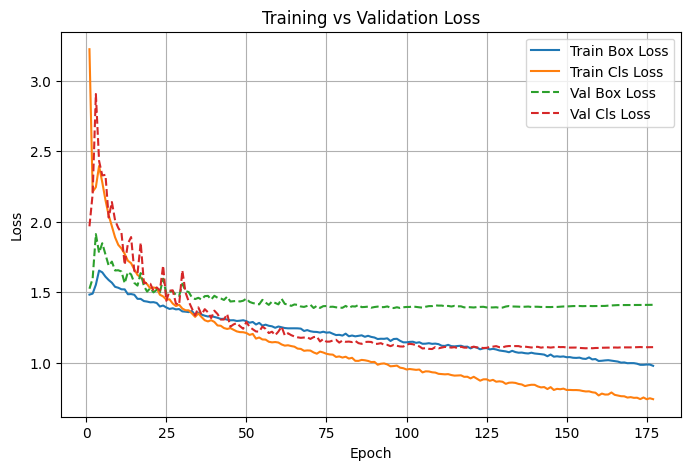

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("runs/detect/exdark_y8n_es/results.csv")

plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Cls Loss")
plt.plot(df["epoch"], df["val/box_loss"], '--', label="Val Box Loss")
plt.plot(df["epoch"], df["val/cls_loss"], '--', label="Val Cls Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

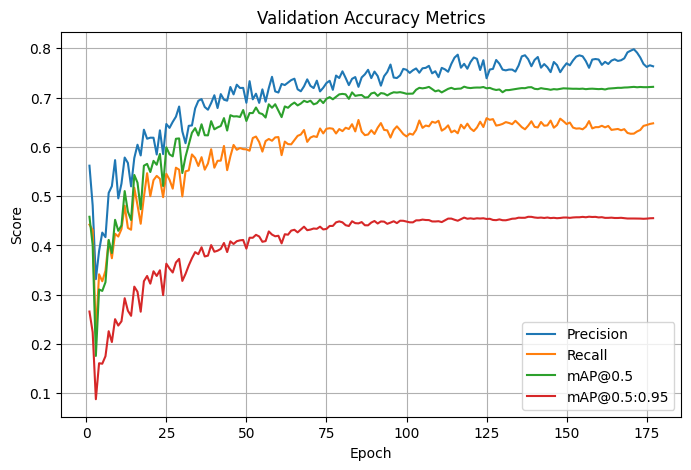

In [16]:
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Accuracy Metrics')
plt.legend()
plt.grid()
plt.show()

In [17]:
!yolo task=detect mode=val \
    model=runs/detect/exdark_y8n_es/weights/best.pt \
    data=/content/exdark.yaml \
    split=test \
    imgsz=640

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1816.2±314.0 MB/s, size: 1118.8 KB)
val: Scanning /content/Output/labels/test... 1105 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1105/1105 974.5it/s 1.1s
val: /content/Output/images/test/2015_01610.jpg: corrupt JPEG restored and saved
val: /content/Output/images/test/2015_02633.jpg: corrupt JPEG restored and saved
val: /content/Output/images/test/2015_02640.jpg: corrupt JPEG restored and saved
val: /content/Output/images/test/2015_03362.jpg: corrupt JPEG restored and saved
val: /content/Output/images/test/2015_05339.jpg: corrupt JPEG restored and saved
val: /content/Output/images/test/2015_06682.jpg: corrupt JPEG restored and saved
val: New cache created: /content/Output/labels/test.cache
                 Class     Images  Instances      Box(P          R 

In [27]:
import os, glob, cv2, torch, numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from transformers import ViTImageProcessor, ViTModel

device = "cuda" if torch.cuda.is_available() else "cpu"

BASE_IN  = "/content/Data/ExDark"         # your folders: Bicycle, Boat, ...
BASE_OUT_MASK   = "/content/Data/ExDark_Mask"     # only mask (grayscale)
BASE_OUT_MASKED = "/content/Data/ExDark_Masked"   # attention-applied RGB image

os.makedirs(BASE_OUT_MASK, exist_ok=True)
os.makedirs(BASE_OUT_MASKED, exist_ok=True)

# ---- Load ViT that returns attentions ----
# You can also try: 'facebook/dino-vitb16'
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTModel.from_pretrained(model_name, output_attentions=True).to(device).eval()
for p in model.parameters(): p.requires_grad = False

def attention_rollout(attentions, discard=0.0):
    """
    attentions: tuple of L tensors, each [B, heads, tokens, tokens]
    returns: [B, tokens] importance of patch tokens relative to CLS
    """
    # average heads at each layer
    attn = [a.mean(dim=1) for a in attentions]  # list of [B, T, T]

    # (optional) discard low attention to sharpen maps
    if discard > 0:
        attn = [torch.clamp(a, min=discard) for a in attn]

    # normalize rows to sum 1
    attn = [a / (a.sum(dim=-1, keepdim=True) + 1e-6) for a in attn]

    # rollout multiply across layers
    R = attn[0]
    for a in attn[1:]:
        R = a @ R  # [B, T, T]

    # CLS is token 0; take its distribution over other tokens (cols)
    # -> importance per token from CLS: row 0 (or column 0 depending on convention).
    # HF ViT uses [CLS] first, so we take row 0 attention TO others:
    # shape [B, T]; drop CLS itself -> patch tokens only
    return R[:, 0, 1:]  # [B, N_patches]

def make_mask_and_apply(img_bgr, base=0.3, gain=2.0):
    # RGB for processor
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    H, W = img_rgb.shape[:2]

    # preprocess
    inputs = processor(images=img_rgb, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)  # [1,3,224,224]

    with torch.no_grad():
        outputs = model(pixel_values, output_attentions=True)
        atts = outputs.attentions  # tuple(L) of [1, heads, T, T]

    roll = attention_rollout(atts, discard=0.0)       # [1, N]
    B, N = roll.shape
    # patch16 => 14x14 grid for 224 image
    g = int((pixel_values.shape[-1] // 16))
    m = roll.view(B, 1, g, g)                         # [1,1,14,14]
    m = F.interpolate(m, size=(H, W), mode="bilinear", align_corners=False)[0,0]
    m = (m - m.min()) / (m.max() - m.min() + 1e-6)    # [0,1]
    gamma = 0.7  # < 1 → boosts high attention, compresses low
    m = m.pow(gamma)

    weight = (base + gain * m).cpu().numpy().astype(np.float32)  # HxW
    out_rgb = (img_rgb.astype(np.float32) * weight[..., None]).clip(0,255).astype(np.uint8)
    out_bgr = cv2.cvtColor(out_rgb, cv2.COLOR_RGB2BGR)
    mask_vis = (m.cpu().numpy() * 255).astype(np.uint8)
    return out_bgr, mask_vis

# gather images recursively
exts = ("*.jpg","*.jpeg","*.png","*.bmp")
all_imgs = []
for e in exts:
    all_imgs += glob.glob(os.path.join(BASE_IN, "**", e), recursive=True)

print(f"Found {len(all_imgs)} images under {BASE_IN}")

for pin in tqdm(all_imgs):
    rel = os.path.relpath(pin, BASE_IN)   # e.g. Bicycle/img001.jpg

    # Build the parallel output paths
    pout_mask   = os.path.join(BASE_OUT_MASK, rel)
    pout_masked = os.path.join(BASE_OUT_MASKED, rel)

    # Ensure folders exist
    os.makedirs(os.path.dirname(pout_mask), exist_ok=True)
    os.makedirs(os.path.dirname(pout_masked), exist_ok=True)

    img = cv2.imread(pin)
    if img is None:
        print("WARN: cannot read", pin)
        continue

    try:
        masked, mask = make_mask_and_apply(img)

        # ----- Save mask -----
        mask_out = pout_mask
        cv2.imwrite(mask_out, mask)

        # ----- Save masked image -----
        masked_out = pout_masked
        cv2.imwrite(masked_out, masked)

    except Exception as e:
        print("ERROR on", pin, "->", e)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found 6696 images under /content/Data/ExDark


100%|██████████| 6696/6696 [04:18<00:00, 25.90it/s]


In [28]:
Records, Missing, Bad = [], 0, 0

Images_Path = Project_Path / "Data" / "ExDark_Masked"
for Class in Classes:
  Images_Directory = Images_Path/Class
  GroundTruth_Directory  = GroundTruthAnnotation_Path/Class

  if not GroundTruth_Directory.exists():
    print(f"No groundtruth directory for class '{Class}': {GroundTruth_Directory}")
    continue

  for Img in sorted(Images_Directory.iterdir()):
    if Img.suffix.lower() not in Images_Format:
      continue

    GroundTruth_txt = GroundTruth_Directory / f"{Img.name}.txt"

    if not GroundTruth_txt.exists():
      Missing += 1
      continue

    try:
      with Image.open(Img) as Im:
        W, H = Im.size
    except Exception:
      Bad += 1
      continue

    Annotations = Exdark_Annotation_File(GroundTruth_txt, W, H, Folder_Class=Class)
    if Annotations:
      Records.append((Img, Annotations))

print(f"Annotated Images: {len(Records)}, Missing GroundTruth.txt: {Missing}, Bad Images: {Bad}")

Annotated Images: 6695, Missing GroundTruth.txt: 0, Bad Images: 0


In [29]:
random.shuffle(Records)
N = len(Records)
N_Train = int(0.70*N)
N_Val = int(0.15*N)
Splits = {"train": Records[:N_Train], "val": Records[N_Train:N_Train+N_Val], "test": Records[N_Train+N_Val:]}
print({k: len(v) for k,v in Splits.items()}, f"Total: {sum(len(v) for v in Splits.values())}")

{'train': 4686, 'val': 1004, 'test': 1005} Total: 6695


In [30]:
for Sp, Items in Splits.items():
    (Output_Masked/"images"/Sp).mkdir(parents=True, exist_ok=True)
    (Output_Masked/"labels"/Sp).mkdir(parents=True, exist_ok=True)
    for (Img, Anns) in Items:
        Img2 = Output_Masked/"images"/Sp/Img.name
        if not Img2.exists():
            shutil.copy2(Img, Img2)
        Lables_Out = Output_Masked/"labels"/Sp/(Img.stem + ".txt")
        with open(Lables_Out, "w") as f:
            for (cls, cx, cy, w, h) in Anns:
                f.write(f"{Classes_ID[cls]} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

print("YOLO dataset built at:", Output_Masked)

YOLO dataset built at: /content/Output_Masked


In [31]:
yaml_text = f"""path: {Output_Masked}
train: /content/Output_Masked/images/train
val: /content/Output_Masked/images/val
test: /content/Output_Masked/images/test
names:
"""
for i,c in enumerate(Classes):
    yaml_text += f"  {i}: {c}\n"
yaml_path = Project_Path / "exdark2.yaml"
yaml_path.write_text(yaml_text)
print("Wrote", yaml_path)
print(yaml_text)

Wrote /content/exdark2.yaml
path: /content/Output_Masked
train: /content/Output_Masked/images/train
val: /content/Output_Masked/images/val
test: /content/Output_Masked/images/test
names:
  0: Bicycle
  1: Boat
  2: Bottle
  3: Bus
  4: Car
  5: Cat
  6: Chair
  7: Cup
  8: Dog
  9: Motorbike
  10: People
  11: Table



In [ ]:
!yolo task=detect mode=train \
     model=yolov8n.pt \
     data=/content/exdark2.yaml \
     imgsz=640 \
     epochs=200 \
     patience=20 \
     batch=32 \
     workers=8 \
     device=0 \
     name=exdark_y8n_es2

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/exdark2.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exdark_y8n_es22, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots

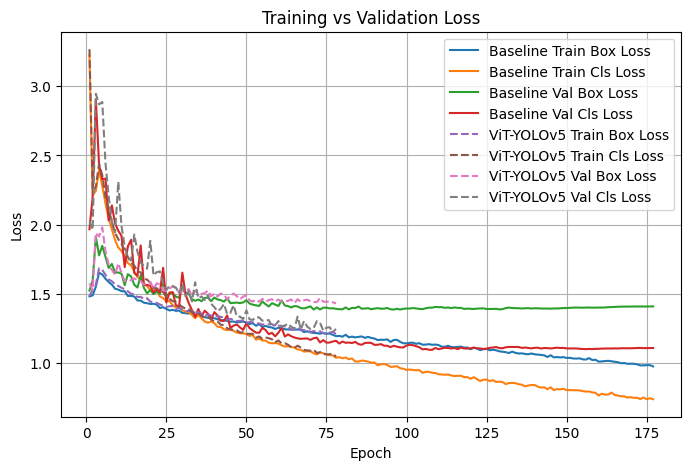

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df2 = pd.read_csv("runs/detect/exdark_y8n_es2/results.csv")

plt.figure(figsize=(8,5))
plt.plot(df["epoch"], df["train/box_loss"], label="Baseline Train Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Baseline Train Cls Loss")
plt.plot(df["epoch"], df["val/box_loss"], label="Baseline Val Box Loss")
plt.plot(df["epoch"], df["val/cls_loss"], label="Baseline Val Cls Loss")
plt.plot(df2["epoch"], df2["train/box_loss"], '--', label="ViT-YOLOv5 Train Box Loss")
plt.plot(df2["epoch"], df2["train/cls_loss"], '--', label="ViT-YOLOv5 Train Cls Loss")
plt.plot(df2["epoch"], df2["val/box_loss"], '--', label="ViT-YOLOv5 Val Box Loss")
plt.plot(df2["epoch"], df2["val/cls_loss"], '--', label="ViT-YOLOv5 Val Cls Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

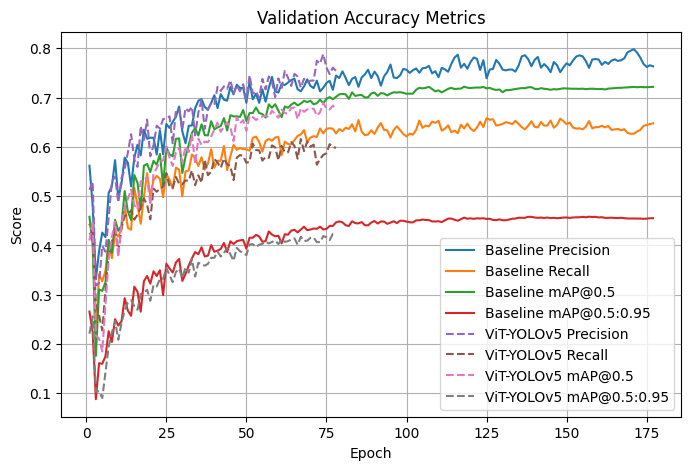

In [26]:
plt.figure(figsize=(8,5))
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Baseline Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Baseline Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='Baseline mAP@0.5')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='Baseline mAP@0.5:0.95')
plt.plot(df2['epoch'], df2['metrics/precision(B)'], '--', label='ViT-YOLOv5 Precision')
plt.plot(df2['epoch'], df2['metrics/recall(B)'], '--', label='ViT-YOLOv5 Recall')
plt.plot(df2['epoch'], df2['metrics/mAP50(B)'], '--', label='ViT-YOLOv5 mAP@0.5')
plt.plot(df2['epoch'], df2['metrics/mAP50-95(B)'], '--', label='ViT-YOLOv5 mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Accuracy Metrics')
plt.legend()
plt.grid()
plt.show()

In [ ]:
!yolo task=detect mode=val \
    model=runs/detect/exdark_y8n_es22/weights/best.pt \
    data=/content/exdark2.yaml \
    split=test \
    imgsz=640

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1778.9±484.3 MB/s, size: 84.4 KB)
val: Scanning /content/Output_Masked/labels/test... 1874 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1874/1874 1.2Kit/s 1.6s
val: New cache created: /content/Output_Masked/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 118/118 12.9it/s 9.2s
                   all       1874       5969      0.926      0.859      0.929      0.717
               Bicycle        188        278      0.968      0.885      0.956      0.773
                  Boat        175        333      0.919      0.859      0.936      0.687
                Bottle        162        339      0.933      0.823      0.913      0.673
                   Bus        133        164      0.943 

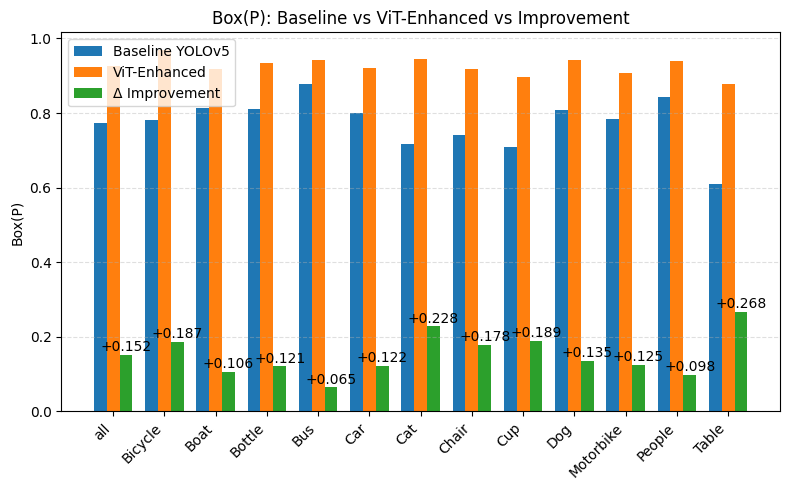

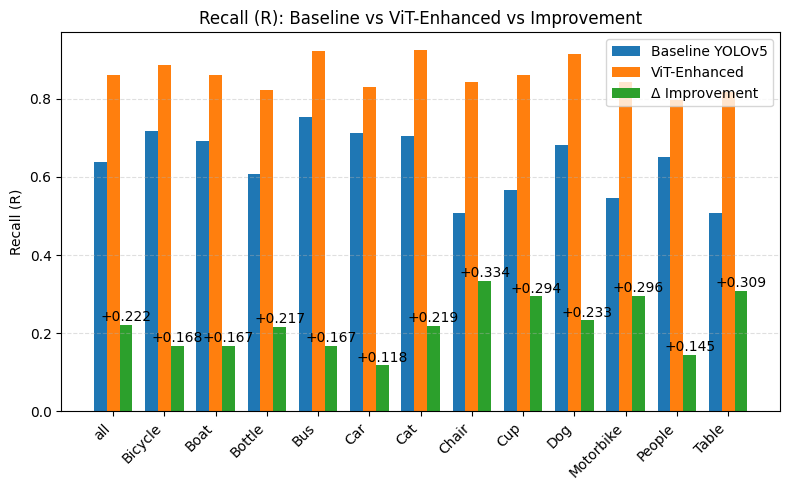

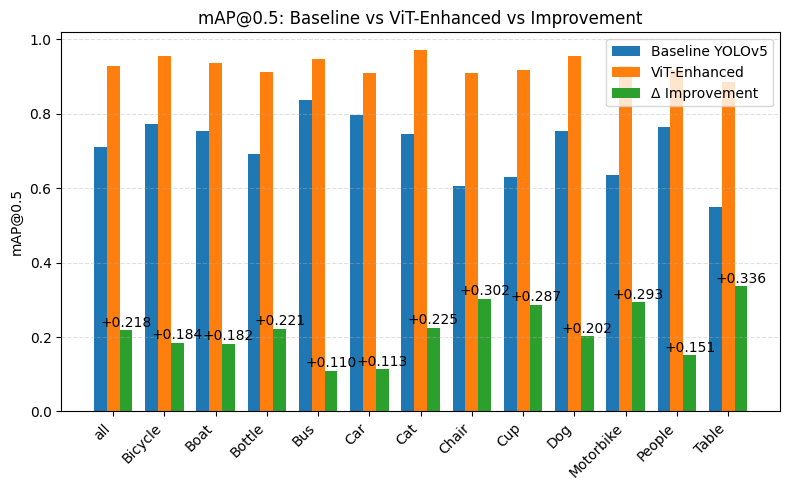

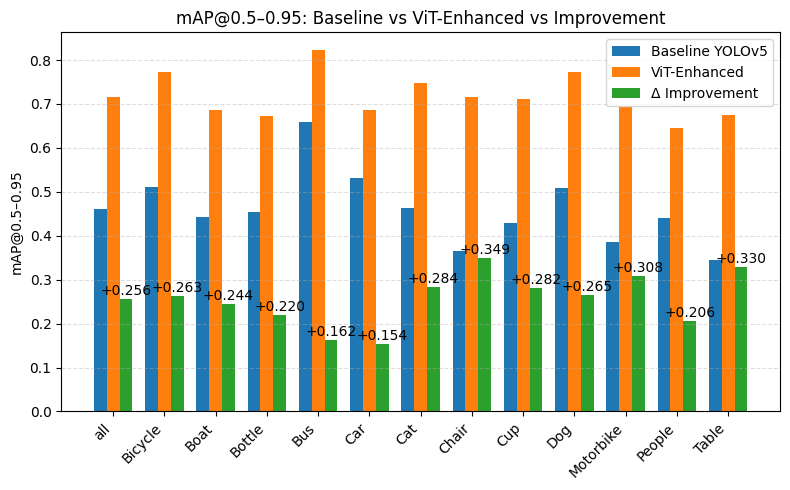

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------
#  METRICS FROM YOUR TABLES
# --------------------------

classes = ["all","Bicycle","Boat","Bottle","Bus","Car","Cat",
           "Chair","Cup","Dog","Motorbike","People","Table"]

# ---- Baseline YOLOv5 ----
baseline_boxP = [0.774,0.781,0.813,0.812,0.878,0.799,0.717,0.741,0.708,0.808,0.783,0.842,0.609]
baseline_R    = [0.637,0.717,0.692,0.606,0.754,0.712,0.704,0.507,0.567,0.681,0.545,0.650,0.507]
baseline_mAP50= [0.711,0.772,0.754,0.692,0.838,0.797,0.745,0.607,0.629,0.754,0.636,0.765,0.548]
baseline_mAP5095=[0.461,0.510,0.443,0.453,0.660,0.532,0.464,0.366,0.430,0.508,0.386,0.440,0.344]

# ---- ViT-enhanced YOLO ----
enh_boxP = boxP = [0.926,  0.968, 0.919,  # Boat
    0.933,  # Bottle
    0.943,  # Bus
    0.921,  # Car
    0.945,  # Cat
    0.919,  # Chair
    0.897,  # Cup
    0.943,  # Dog
    0.908,  # Motorbike
    0.940,  # People
    0.877   # Table
]

enh_R    = [
    0.859,  # all
    0.885,  # Bicycle
    0.859,  # Boat
    0.823,  # Bottle
    0.921,  # Bus
    0.830,  # Car
    0.923,  # Cat
    0.841,  # Chair
    0.861,  # Cup
    0.914,  # Dog
    0.841,  # Motorbike
    0.795,  # People
    0.816   # Table
]

enh_mAP50= [
    0.929,  # all
    0.956,  # Bicycle
    0.936,  # Boat
    0.913,  # Bottle
    0.948,  # Bus
    0.910,  # Car
    0.970,  # Cat
    0.909,  # Chair
    0.916,  # Cup
    0.956,  # Dog
    0.929,  # Motorbike
    0.916,  # People
    0.884   # Table
]

enh_mAP5095=[
    0.717,  # all
    0.773,  # Bicycle
    0.687,  # Boat
    0.673,  # Bottle
    0.822,  # Bus
    0.686,  # Car
    0.748,  # Cat
    0.715,  # Chair
    0.712,  # Cup
    0.773,  # Dog
    0.694,  # Motorbike
    0.646,  # People
    0.674   # Table
]


def plot_metric(classes, baseline, enhanced, metric_name):
    baseline = np.array(baseline)
    enhanced = np.array(enhanced)
    improvement = enhanced - baseline

    x = np.arange(len(classes))
    w = 0.25

    plt.figure(figsize=(8,5))

    plt.bar(x - w, baseline, width=w, label="Baseline YOLOv5")
    plt.bar(x, enhanced, width=w, label="ViT-Enhanced")
    plt.bar(x + w, improvement, width=w, label="Δ Improvement")

    # label delta values
    for i, v in enumerate(improvement):
        plt.text(x[i] + w, v + (0.002 if v >= 0 else -0.01),
                 f"{v:+.3f}", ha="center",
                 va="bottom" if v >= 0 else "top")

    plt.xticks(x, classes, rotation=45, ha="right")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name}: Baseline vs ViT-Enhanced vs Improvement")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_metric(classes, baseline_boxP, enh_boxP, "Box(P)")
plot_metric(classes, baseline_R,    enh_R,    "Recall (R)")
plot_metric(classes, baseline_mAP50, enh_mAP50, "mAP@0.5")
plot_metric(classes, baseline_mAP5095, enh_mAP5095, "mAP@0.5–0.95")